# Codelab 2: Kalman Filter

We are going to implement a Kalman filter to track a car moving in the 1D world.

## Where are we?

We are in line-world, better known as the 1D world that is 100 units long.

We want to implement a Kalman filter to implement a move and sense model to track a moving robot. We will first example the prediction updates, and then the measurement updates.

Let us take a look at the prediction update equations for both state and covariance (Σ).

## Prediction

$$\vec{\mu_t} = \mathbf{A}(\vec{\mu_{t-1}}) + \mathbf{B}(\vec{control\_signal})$$

$$
\Sigma_{t} = \mathbf{A} \Sigma_{t-1}\mathbf{A}^T + \mathbf{R}_t
$$

**μ**: This is your state, and will be a 2D vector, containing the position and the velocity. Note that even though we are moving in a 1D world, we can make our state have as many dimensions as we want.

**control_signal**: This will be a scalar that represents acceleration, or change in velocity.

**state_transition_model** (A): This is how your state updates itself. You can think of it as, "given my current position and velocity, how would I update myself?"

**control_input_model** (B): This is how your state takes into account an external control, and translates it into a state change. You can think of this as translating the acceleration control signal into an actual velocity change.

**Σ**: This is your covariance matrix. Think of this as standard deviation extended into multiple dimensions. You may be thinking, "Why do we have a matrix if we are moving in a 1D world?" This is because our _state vector is two dimensional because it contains both position and velocity_.

**R**: This is the covariance of our movement function. We will define this later on.

The state update function denoted above is a function of state and control_signal. However, we still need to figure out what A and B are.

### state_transition_model (A)

We know that **A** is applied to our state vector, which is a vector that looks like the following.

$$
\vec{\mu_t}=
\begin{pmatrix}
position \\
velocity
\end{pmatrix}
$$

Intuitively, A is the matrix that finds the next state based on the previous one. From the example in class with the bacteria that doubled itself every timestep, A would be 2. For this case, we need to understand how position updates based on velocity to construct A. We know the following:

\begin{split} 
\color{deeppink}{p_t} &= \color{royalblue}{p_{t-1}} + \Delta t &\color{royalblue}{v_{t-1}} \\ 
\color{deeppink}{v_t} &= &\color{royalblue}{v_{t-1}} 
\end{split}

We can assume that our change in time will be 1. We know our state vector is the following:

$$
\vec{\mu_t}=
\begin{pmatrix}
\color{royalblue}{p_{t-1}} \\
\color{royalblue}{v_{t-1}}
\end{pmatrix}
$$

So, what matrix, when multiplied by that state vector, will yield the updated position and velocity values as depicted by the equation above? Try filling in your A below, and run the block of code until you see "All tests passed!"

In [164]:
import numpy as np

A = np.array([[1,1],
              [0,1]])

def test_A_matrix():
    test_1 = np.array([3,1])
    test_2 = np.array([2,5])
    test_3 = np.array([53,0])
    if not np.array_equal(np.dot(A, test_1), np.array([4,1])):
        return 'Test 1 not passing.'
    if not np.array_equal(np.dot(A, test_2), np.array([7,5])):
        return 'Test 2 not passing.'
    if not np.array_equal(np.dot(A, test_3), np.array([53,0])):
        return 'Test 3 not passing.'
    return 'All tests passed!'
    
print test_A_matrix()

All tests passed!


Now that we have A, we need to construct B. 

### control_input (B)

B is defined as the control_input model. In our case, the control_input will always be acceleration. You can think of this like pressing a gas pedal down in a car - this changes your acceleration, which in turn affects your state.

The product of B and the control_signal should yield a 2x1 vector (as that is the size of our state) that should update the state accordingly. In other words, if you know you are pressing down on the accelerator, the velocity should go up.

We know the velocity update equation looks like the following:

$$
\color{deeppink}{v_t} = \color{royalblue}{v_{t-1}} + \Delta t \color{royalblue}{a_{t-1}} 
$$


You can assume the acceleration will be a 1x1 matrix, and the timestep will be 1. Given that B needs to model the above update equation, what would it look like? Put your guess for B below, and then run the tests to see if you got it!

In [66]:
B = np.array([[0],
              [1]])

def test_B_matrix():
    if not np.array_equal(np.dot(B, np.array([[3]])), np.array([[0],[3]])):
        return 'Test 1 not passing.'
    if not np.array_equal(np.dot(B, np.array([[-2]])), np.array([[0],[-2]])):
        return 'Test 2 not passing.'
    if not np.array_equal(np.dot(B, np.array([[0]])), np.array([[0],[0]])):
        return 'Test 3 not passing.'
    return 'All tests passed!'
    
print test_B_matrix()

All tests passed!


We must also update our variances within our _covariance matrix_. The equation for the covariance update is the following:

$$
\Sigma_{t} = \mathbf{A} \Sigma_{t-1}\mathbf{A}^T + \mathbf{R}_t
$$

In the case of self-driving cars, engineers will measure the variance in movement and then create the R matrix experimentally. In our case, we obviously do not have the resources to do this. So, we will just define it.

In [165]:
R = np.array([[20,0],
              [0,5]])

Now, we can implement our prediction update!

In [167]:
# To multiply to matrices, use np.dot(m1, m2)
# To take the transpose of a matrix, use np.transpose(m)

def prediction_update(state, covariance, control_signal):
    new_state = np.dot(A, state) + np.dot(B, control_signal)
    new_covariance = np.dot(np.dot(A, covariance), np.transpose(A)) + R
    return new_state, new_covariance

### Measurement Update

The formulas for the measurement update are the following:

$$
K_{t} = \Sigma_{t} C_t^T (C_t \Sigma_t C_t^T + Q_t)^{-1} \\
\mu_t = \mu_t + K_t(z_t - C_t\mu_t) \\
\Sigma_t = (I - K_tC_t)\Sigma_t
$$

Let's define all of the new variables.

**C**: This is the transformation matrix from the state space of your state vector into the space of measurements. In the case of the bacteria example where we measured concentration of a particular chemical that bacteria produce, this would be some sort of equation to convert number of bacteria into expected concentration.

**Q**: This is the uncertainty in your sensor. In the bacteria example, this would be how much variation we expect in our sensing of the chemical concentration.

**K**: This is known as the _Kalman Gain_. Intuitively, you can think of this as how much we incorporate this measurement into updating our state.

**z**: This is your observed measurement.

**I**: This is the identity matrix.

For **C**, we want a matrix that transforms our state vector (p, v) into what we would expect the measurement to be for this state. Again, we are only tracking position. In other words, we need need to find a C such that:

$$
C_t\begin{pmatrix}
p \\
v
\end{pmatrix} = 
\begin{pmatrix}
p
\end{pmatrix}
$$

When you think you got it, fill in C below and use the tests to see if you got it!

In [170]:
C = np.array([[1, 0]])

def test_C_matrix():
    if not np.array_equal(np.array([[0]]),np.dot(C, np.array([[0],[3]]))):
        return 'Test 1 not passing.'
    if not np.array_equal(np.array([[4000]]),np.dot(C, np.array([[4000],[3312]]))):
        return 'Test 2 not passing.'
    if not np.array_equal(np.array([[48]]),np.dot(C, np.array([[48],[-43214]]))):
        return 'Test 3 not passing.'
    return 'All tests passed!'
print test_C_matrix()

All tests passed!


Next, we must define **Q**. This is how noisy our sensor is. Typically, this is figured out through running experiments, but we will just tell you that our readings will be noisy with a standard deviation of 10.

In [171]:
Q = np.array([10])

Next, we will give to you a function to get our measurements given a state (μ). All this function will do is take your state, convert it into a measurement with the previously defined **C** matrix, and then corrupt it with some noise to simulate real world sensors. Also, let's define **I** because why not?

In [172]:
def get_noisy_measurement(state):
    z = np.dot(C, state)
    return np.random.normal(z[0], Q, 1)

I = np.array([[1,0],[0,1]])

Now, we are ready to write the measurement update!

In [173]:
def measurement_update(state, covariance):
    K1 = np.dot(covariance, np.transpose(C))
    K2 = np.linalg.inv(np.dot(np.dot(C,covariance), np.transpose(C)) + Q)
    kalman_gain = np.dot(K1,K2)
    z = get_noisy_measurement(state)
    new_state = state + np.dot(kalman_gain,z - np.dot(C, state))
    new_covariance = np.dot(I - np.dot(kalman_gain, C),covariance)
    return new_state, new_covariance

### Initial State

Let's say our initial belief is that we are at position 50 with a velocity of about 20. Let's model this uncertainty by giving our covariance matrix a position variance of 30 (we are very uncertain) and velocity variance of 3. Run the below code to see our initial distribution.

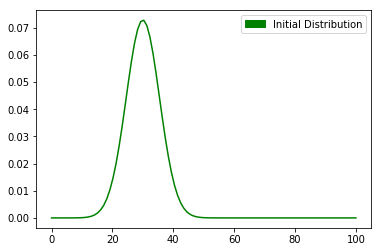

In [174]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import math

# initial state
state = np.array([[30],[20]])
covariance = np.array([[30,0],
                       [0,3]])

# getting numbers for plot
position = state[0][0]
variance = covariance[0][0]

# plot!
x = np.linspace(0, 100, 100)
plt.plot(x,mlab.normpdf(x, position, math.sqrt(variance)),color="green")
green_patch = mpatches.Patch(color='green', label='Initial Distribution')
plt.legend(handles=[green_patch])
plt.show()

### Prediction #1 (Constant Velocity)

Now, let's move! With our initial state, it follows that we'd expect to move 20 spaces forward (because that is our velocity) and end up around 80. However, this should add some uncertainty. We can hold off on adding a control signal for now.

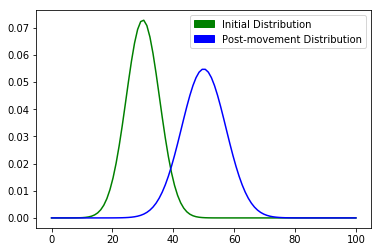

In [175]:
# get numbers for plot 1
position = state[0][0]
variance = covariance[0][0]

# set up plot 1
x = np.linspace(0, 100, 100)
plt.plot(x,mlab.normpdf(x, position, math.sqrt(variance)),color="green")
state, covariance = movement_update(state, covariance, np.array([[0]]))

# get numbers for plot 2
position = state[0][0]
variance = covariance[0][0]

# set up plot 2
plt.plot(x,mlab.normpdf(x, state[0][0], math.sqrt(variance)),color="blue")
green_patch = mpatches.Patch(color='green', label='Initial Distribution')
blue_patch = mpatches.Patch(color='blue', label='Post-movement Distribution')
plt.legend(handles=[green_patch, blue_patch])
plt.show()

This looks like what we'd expect! Our initial distribution was peaky, and it become flatter because movement introduces more uncertainty. Now, let's measure.

### Measurement #1

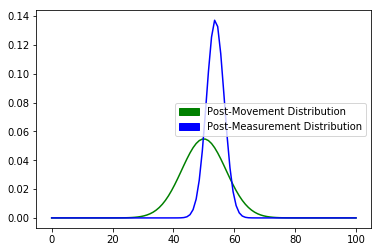

In [161]:
position = state[0][0]
variance = covariance[0][0]
x = np.linspace(0, 100, 100)
plt.plot(x,mlab.normpdf(x, position, math.sqrt(variance)),color="green")
state, covariance = measurement_update(state, covariance)
position = state[0][0]
variance = covariance[0][0]
plt.plot(x,mlab.normpdf(x, state[0][0], math.sqrt(variance)),color="blue")
green_patch = mpatches.Patch(color='green', label='Post-Movement Distribution')
blue_patch = mpatches.Patch(color='blue', label='Post-Measurement Distribution')
plt.legend(handles=[green_patch, blue_patch])
plt.show()

This is also exactly what we'd expect! We go from a flat distribution to a much peakier distribution because that is what sensing does. Let's move again, but this time toss in a control signal to start reversing the direction (negative acceleration).

### Prediction #2 (Negative Acceleration)

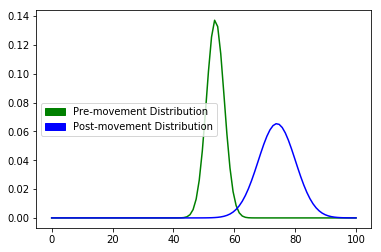

In [162]:
position = state[0][0]
variance = covariance[0][0]
x = np.linspace(0, 100, 100)
plt.plot(x,mlab.normpdf(x, position, math.sqrt(variance)),color="green")
state, covariance = movement_update(state, covariance, np.array([[-10]]))
position = state[0][0]
variance = covariance[0][0]
plt.plot(x,mlab.normpdf(x, state[0][0], math.sqrt(variance)),color="blue")
green_patch = mpatches.Patch(color='green', label='Pre-movement Distribution')
blue_patch = mpatches.Patch(color='blue', label='Post-movement Distribution')
plt.legend(handles=[green_patch, blue_patch])
plt.show()

### Meaurement #2

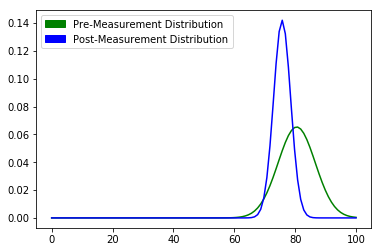

In [157]:
position = state[0][0]
variance = covariance[0][0]
x = np.linspace(0, 100, 100)
plt.plot(x,mlab.normpdf(x, position, math.sqrt(variance)),color="green")
state, covariance = measurement_update(state, covariance)
position = state[0][0]
variance = covariance[0][0]
plt.plot(x,mlab.normpdf(x, state[0][0], math.sqrt(variance)),color="blue")
green_patch = mpatches.Patch(color='green', label='Pre-Measurement Distribution')
blue_patch = mpatches.Patch(color='blue', label='Post-Measurement Distribution')
plt.legend(handles=[green_patch, blue_patch])
plt.show()